# EAST Data Preprocessing

**Paper** : https://arxiv.org/abs/1704.03155v2   
**Dataset ICDAR** : [2019](http://rrc.cvc.uab.es/?ch=13)   
- Use Google Drive Link: https://drive.google.com/drive/folders/1ShItNWXyiY1tFDM5W02bceHuJjyeeJl2 
and download the files

## Text Localization:
- All images are provided as JPEG or PNG files and the text files are UTF-8 files with CR/LF new line endings.
- The ground truth is given as separate text files (one per image) where each line specifies the coordinates of one 
word's bounding box and its transcription in a comma separated format 
- [2019](http://rrc.cvc.uab.es/?ch=13&com=tasks)

img_1.png <-> img_01.txt

```sh
x1_1, y1_1,x2_1,y2_1,x3_1,y3_1,x4_1,y4_1, transcript_1

x1_2,y1_2,x2_2,y2_2,x3_2,y3_2,x4_2,y4_2, transcript_2

x1_3,y1_3,x2_3,y2_3,x3_3,y3_3,x4_3,y4_3, transcript_3
```

In [1]:
import glob
import csv
import cv2
import time
import os
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
import matplotlib.patches as Patches
import matplotlib.image as mpimg
from shapely.geometry import Polygon
from IPython.display import display, Image

%matplotlib inline
# %matplot inline

In [2]:
import tensorflow as tf

In [3]:
import time
import numpy as np
import threading
import multiprocessing
try:
    import queue
except ImportError:
    import Queue as queue

In [4]:
training_data_path = ""
max_image_large_side = 1280
max_text_size = 800
min_text_size = 10
min_crop_side_ratio = 0.1
geometry = "RBOX"

In [5]:
!ls data/SROIE2019/train/

X00016469612.jpg  X00016469622.txt  X00016469676.jpg  X51005255805.txt
X00016469612.txt  X00016469623.jpg  X00016469676.txt  X51005268200.jpg
X00016469619.jpg  X00016469623.txt  X51005200938.jpg  X51005268200.txt
X00016469619.txt  X00016469669.jpg  X51005200938.txt  X51005268262.jpg
X00016469620.jpg  X00016469669.txt  X51005230617.jpg  X51005268262.txt
X00016469620.txt  X00016469672.jpg  X51005230617.txt  X51005268400.jpg
X00016469622.jpg  X00016469672.txt  X51005255805.jpg  X51005268400.txt


In [6]:
training_data_path = "data/SROIE2019/train/"

In [41]:
def display_image_in_actual_size(im_path=None, im_data=None):

    dpi = 80
    if im_path:
        im_data = plt.imread(im_path)
        
    height, width, depth = im_data.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()


In [42]:
def get_images(data_path):
    """
    find image files in test data path
    :return: list of files found
    """

    files = []
    exts = ['jpg', 'png', 'jpeg', 'JPG']
    for parent, dirnames, filenames in os.walk(data_path):
        for filename in filenames:
            for ext in exts:
                if filename.endswith(ext):
                    files.append(os.path.join(parent, filename))
                    break
    print('Found {} images'.format(len(files)))
    return files

Found 14 images
Height 1390, Width 807


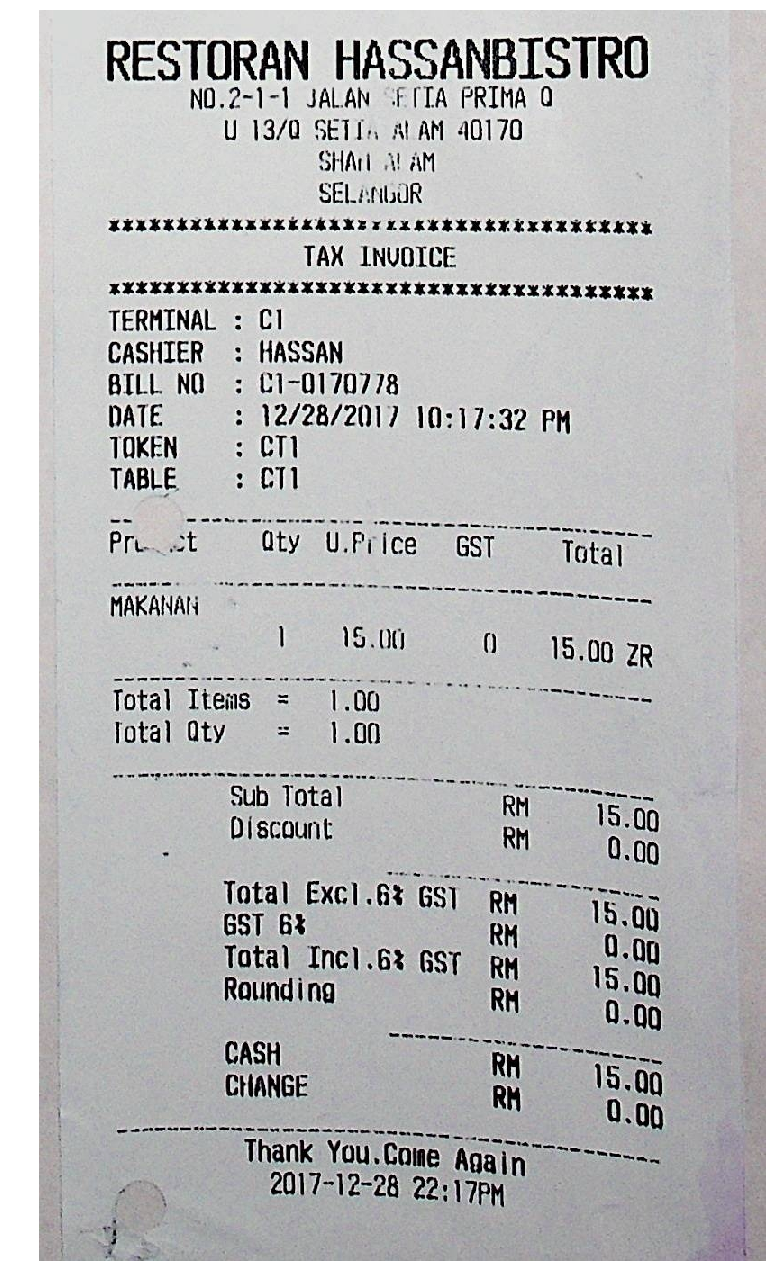

In [43]:
images = get_images(data_path=training_data_path)
image_file_name = images[0]
im = cv2.imread(image_file_name)
# print im_fn
h, w, _ = im.shape
print("Height {}, Width {}".format(h,w))
display_image_in_actual_size(im_data=im)

In [44]:
image_file_name

'data/SROIE2019/train/X51005268400.jpg'

In [45]:
text_file_name = image_file_name.replace(".jpg", ".txt")

In [46]:
! cat data/SROIE2019/train/X51005268400.txt

72,27,680,27,680,81,72,81,RESTORAN HASSANBISTRO
165,82,572,82,572,111,165,111,NO.2-1-1 JALAN SETIA PRIMA Q
203,119,539,119,539,147,203,147,U 13/Q SETIA ALAM 40170
309,154,442,154,442,182,309,182,SHAM ALAM
308,189,427,189,427,216,308,216,SELANGOR
292,260,466,260,466,288,292,288,TAX INVOICE
75,330,273,330,273,358,75,358,TERMINAL : C1
253,1289,518,1289,518,1331,253,1331,2017-12-28 22:17PM
225,1252,542,1252,542,1297,225,1297,THANK YOU.COME AGAIN
75,367,184,367,184,394,75,394,CASHIER
216,365,339,365,339,394,216,394,: HASSAN
628,1208,694,1208,694,1247,628,1247,0.00
74,401,184,401,184,429,74,429,BILL NO
215,399,401,399,401,430,215,430,: C1-0170778
501,1194,537,1194,537,1226,501,1226,RM
75,437,140,437,140,464,75,464,DATE
216,437,592,437,592,471,216,471,: 12/28/2017 10:17:32 PM
204,1179,301,1179,301,1210,204,1210,CHANGE
76,471,155,471,155,500,76,500,TOKEN
215,471,289,471,289,499,215,499,: CT1
614,1168,694,1168,694,1208,614,1208,15.00
76,505,154,505,154,535,76,535,TABLE
216,506,289,506,289,535,2

In [47]:
def load_annoataion(txt_file_path):
    """
    load annotation from the text file
    "x1, y1, x2, y2, x3, y3, x4, y4, transcription"

    :param txt_file_path:
    :return:
    """

    text_polys = []
    text_tags = []  # mask used in training, to ignore some text annotated by ###
    # if not os.path.exists(p):
    #     return np.array(text_polys, dtype=np.float32)

    try:
        f = open(txt_file_path, 'r')
    except FileNotFoundError:
        raise FileNotFoundError
    else:
        with f:
            reader = csv.reader(f)
            for line in reader:
                label = line[-1]
                # strip BOM. \ufeff for python3,  \xef\xbb\bf for python2
                line = [i.strip('\ufeff').strip('\xef\xbb\xbf') for i in line]

                x1, y1, x2, y2, x3, y3, x4, y4 = list(map(float, line[:8]))
                text_polys.append([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])
                # In ICDAR 2015 dataset unreadable text regions are annotated with either * or #
                if label == '*' or label == '###':
                    text_tags.append(True)
                else:
                    text_tags.append(False)

            return np.array(text_polys, dtype=np.float32), np.array(text_tags, dtype=np.bool)

In [48]:
text_polys, text_tags = load_annoataion(txt_file_path=text_file_name)
print(text_polys[0])
print(text_tags[0])

[[ 72.  27.]
 [680.  27.]
 [680.  81.]
 [ 72.  81.]]
False


### Polygon Area
- https://math.stackexchange.com/questions/1259094/coordinate-geometry-area-of-a-quadrilateral


**[Shoelace formula](https://en.wikipedia.org/wiki/Shoelace_formula)**

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/e3259a46fc166c8eba4bdc1d50ad0a8b81934cee)

In [49]:
def polygon_area(poly):
    """
    compute area of a polygon
    :param poly:
    :return:
    """

    """
    https://math.stackexchange.com/questions/1259094/coordinate-geometry-area-of-a-quadrilateral
    https://en.wikipedia.org/wiki/Shoelace_formula
     |0 |1 |
    -|--|--|
    0|x1|y1|
    1|x2|y2|
    2|x3|y3|
    3|x4|y4|

    x1,y1                          x2,y2
    ----------------------------------
    |                                |
    |                                |
    |                                |
    ----------------------------------
    x4,y4                         x3,y3
    
    (x-y)(a+b) = xa + xb − ya − yb
    """

    edge = [
        #  (x2 - x1) * (y2 + y1) = x2y2 + x2y1 - x1y2 - x1y1
        (poly[1][0] - poly[0][0]) * (poly[1][1] + poly[0][1]),
        #  (x3 - x2) * (y3 + y2) = x3y3 + x3y2 - x2y3 -x2y2
        (poly[2][0] - poly[1][0]) * (poly[2][1] + poly[1][1]),
        #  (x4 - x3) * (y4 + y3) = x4y4 + x4y3 - x3y4 - x3y3
        (poly[3][0] - poly[2][0]) * (poly[3][1] + poly[2][1]),
        #  (x1 - x4) * (y1 + y4) = x1y1 + x1y4 - x4y1 - x4y4
        (poly[0][0] - poly[3][0]) * (poly[0][1] + poly[3][1])
    ]
    
    return np.sum(edge) / 2.

In [50]:
polygon_area(text_polys[0])

-32832.0

In [51]:
def check_and_validate_polys(polys, tags, height_weight_tuple):
    """
    check so that the text poly is in the same direction,
    and also filter some invalid polygons
    :param polys:
    :param tags:
    :return:
    """

    (h, w) = height_weight_tuple

    if polys.shape[0] == 0:
        return polys

    polys[:, :, 0] = np.clip(polys[:, :, 0], 0, w - 1)
    polys[:, :, 1] = np.clip(polys[:, :, 1], 0, h - 1)

    validated_polys = []
    validated_tags = []

    for poly, tag in zip(polys, tags):
        p_area = polygon_area(poly)
        if abs(p_area) < 1:
            print('invalid poly')
            continue
        if p_area > 0:  # TODO what maths is involved?
            print('poly in wrong direction')
            # rows are inter changed
            poly = poly[(0, 3, 2, 1), :]
        validated_polys.append(poly)
        validated_tags.append(tag)
    return np.array(validated_polys), np.array(validated_tags)

In [52]:
text_polys, text_tags = check_and_validate_polys(text_polys, text_tags, (h, w))
print(text_polys[0])
print(text_tags[0])

[[ 72.  27.]
 [680.  27.]
 [680.  81.]
 [ 72.  81.]]
False


In [53]:
def crop_area(im, polys, tags, min_crop_side_ratio=0.1, crop_background=False, max_tries=50):
    '''
    make random crop from the input image
    :param im:
    :param polys:
    :param tags:
    :param crop_background:
    :param max_tries:
    :return:
    '''
    h, w, _ = im.shape
    pad_h = h//10
    pad_w = w//10
    h_array = np.zeros((h + pad_h*2), dtype=np.int32)
    w_array = np.zeros((w + pad_w*2), dtype=np.int32)
    for poly in polys:
        poly = np.round(poly, decimals=0).astype(np.int32)
        minx = np.min(poly[:, 0])
        maxx = np.max(poly[:, 0])
        w_array[minx+pad_w:maxx+pad_w] = 1
        miny = np.min(poly[:, 1])
        maxy = np.max(poly[:, 1])
        h_array[miny+pad_h:maxy+pad_h] = 1
    # ensure the cropped area not across a text
    h_axis = np.where(h_array == 0)[0]
    w_axis = np.where(w_array == 0)[0]
    if len(h_axis) == 0 or len(w_axis) == 0:
        return im, polys, tags
    for i in range(max_tries):
        xx = np.random.choice(w_axis, size=2)
        xmin = np.min(xx) - pad_w
        xmax = np.max(xx) - pad_w
        xmin = np.clip(xmin, 0, w-1)
        xmax = np.clip(xmax, 0, w-1)
        yy = np.random.choice(h_axis, size=2)
        ymin = np.min(yy) - pad_h
        ymax = np.max(yy) - pad_h
        ymin = np.clip(ymin, 0, h-1)
        ymax = np.clip(ymax, 0, h-1)
        if xmax - xmin < min_crop_side_ratio*w or ymax - ymin < min_crop_side_ratio*h:
            # area too small
            continue
        if polys.shape[0] != 0:
            poly_axis_in_area = (polys[:, :, 0] >= xmin) & (polys[:, :, 0] <= xmax) \
                                & (polys[:, :, 1] >= ymin) & (polys[:, :, 1] <= ymax)
            selected_polys = np.where(np.sum(poly_axis_in_area, axis=1) == 4)[0]
        else:
            selected_polys = []
        if len(selected_polys) == 0:
            # no text in this area
            if crop_background:
                return im[ymin:ymax+1, xmin:xmax+1, :], polys[selected_polys], tags[selected_polys]
            else:
                continue
        im = im[ymin:ymax+1, xmin:xmax+1, :]
        polys = polys[selected_polys]
        tags = tags[selected_polys]
        polys[:, :, 0] -= xmin
        polys[:, :, 1] -= ymin
        return im, polys, tags

    return im, polys, tags


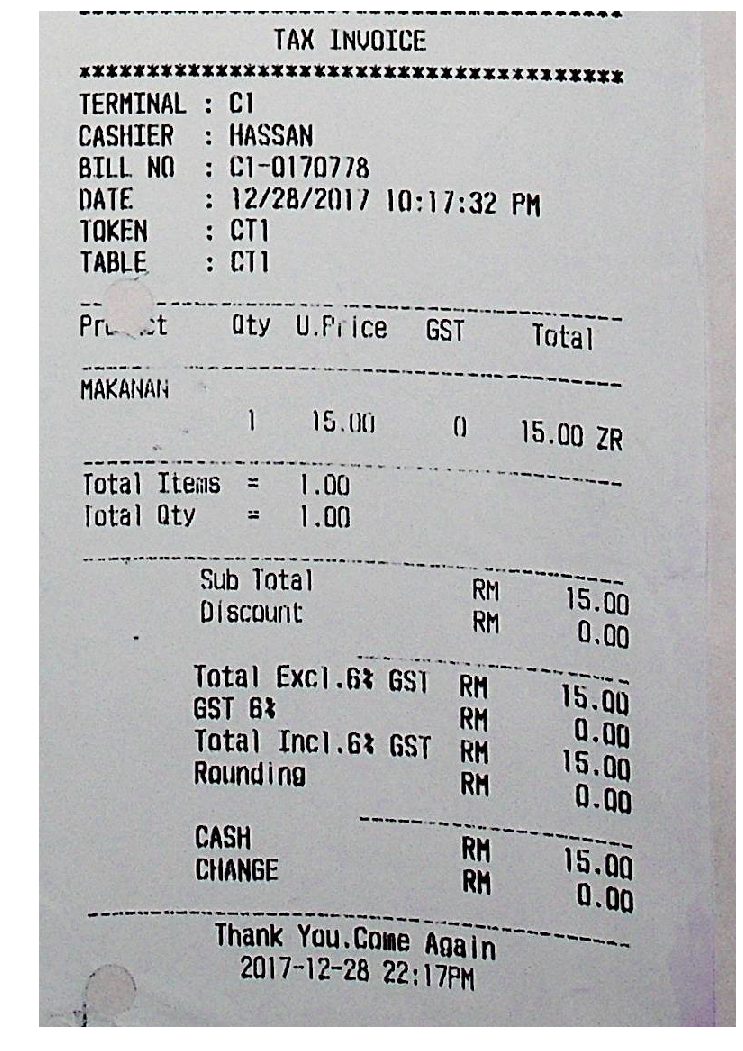

(1129, 774, 3)
(55, 4, 2)
(55,)


In [54]:
im_cropped, polys_cropped, tags_cropped = crop_area(im=im, polys=text_polys, tags=text_tags, min_crop_side_ratio=0.1, crop_background=False, max_tries=50)

display_image_in_actual_size(im_data=im_cropped)
print(im_cropped.shape)
print(polys_cropped.shape)
print(tags_cropped.shape)

In [55]:

def shrink_poly(poly, r):
    '''
    fit a poly inside the origin poly, maybe bugs here...
    used for generate the score map
    :param poly: the text poly
    :param r: r in the paper
    :return: the shrinked poly
    '''
    # shrink ratio
    R = 0.3
    # find the longer pair
    if np.linalg.norm(poly[0] - poly[1]) + np.linalg.norm(poly[2] - poly[3]) > \
                    np.linalg.norm(poly[0] - poly[3]) + np.linalg.norm(poly[1] - poly[2]):
        # first move (p0, p1), (p2, p3), then (p0, p3), (p1, p2)
        ## p0, p1
        theta = np.arctan2((poly[1][1] - poly[0][1]), (poly[1][0] - poly[0][0]))
        poly[0][0] += R * r[0] * np.cos(theta)
        poly[0][1] += R * r[0] * np.sin(theta)
        poly[1][0] -= R * r[1] * np.cos(theta)
        poly[1][1] -= R * r[1] * np.sin(theta)
        ## p2, p3
        theta = np.arctan2((poly[2][1] - poly[3][1]), (poly[2][0] - poly[3][0]))
        poly[3][0] += R * r[3] * np.cos(theta)
        poly[3][1] += R * r[3] * np.sin(theta)
        poly[2][0] -= R * r[2] * np.cos(theta)
        poly[2][1] -= R * r[2] * np.sin(theta)
        ## p0, p3
        theta = np.arctan2((poly[3][0] - poly[0][0]), (poly[3][1] - poly[0][1]))
        poly[0][0] += R * r[0] * np.sin(theta)
        poly[0][1] += R * r[0] * np.cos(theta)
        poly[3][0] -= R * r[3] * np.sin(theta)
        poly[3][1] -= R * r[3] * np.cos(theta)
        ## p1, p2
        theta = np.arctan2((poly[2][0] - poly[1][0]), (poly[2][1] - poly[1][1]))
        poly[1][0] += R * r[1] * np.sin(theta)
        poly[1][1] += R * r[1] * np.cos(theta)
        poly[2][0] -= R * r[2] * np.sin(theta)
        poly[2][1] -= R * r[2] * np.cos(theta)
    else:
        ## p0, p3
        # print poly
        theta = np.arctan2((poly[3][0] - poly[0][0]), (poly[3][1] - poly[0][1]))
        poly[0][0] += R * r[0] * np.sin(theta)
        poly[0][1] += R * r[0] * np.cos(theta)
        poly[3][0] -= R * r[3] * np.sin(theta)
        poly[3][1] -= R * r[3] * np.cos(theta)
        ## p1, p2
        theta = np.arctan2((poly[2][0] - poly[1][0]), (poly[2][1] - poly[1][1]))
        poly[1][0] += R * r[1] * np.sin(theta)
        poly[1][1] += R * r[1] * np.cos(theta)
        poly[2][0] -= R * r[2] * np.sin(theta)
        poly[2][1] -= R * r[2] * np.cos(theta)
        ## p0, p1
        theta = np.arctan2((poly[1][1] - poly[0][1]), (poly[1][0] - poly[0][0]))
        poly[0][0] += R * r[0] * np.cos(theta)
        poly[0][1] += R * r[0] * np.sin(theta)
        poly[1][0] -= R * r[1] * np.cos(theta)
        poly[1][1] -= R * r[1] * np.sin(theta)
        ## p2, p3
        theta = np.arctan2((poly[2][1] - poly[3][1]), (poly[2][0] - poly[3][0]))
        poly[3][0] += R * r[3] * np.cos(theta)
        poly[3][1] += R * r[3] * np.sin(theta)
        poly[2][0] -= R * r[2] * np.cos(theta)
        poly[2][1] -= R * r[2] * np.sin(theta)
    return poly


In [56]:
poly = text_polys[1]

reference_length = [None, None, None, None]
for i in range(4):
    # find the shorted edge distances(vertices1,vertices2)
    # (0,1) | (1,2) | (2,3) | (3,0) <- (i+1) % 4
    # (0,3) | (1,0) | (2,1) | (3,2) <- (i-1) % 4
    reference_length[i] = min(np.linalg.norm(poly[i] - poly[(i + 1) % 4]),
                              np.linalg.norm(poly[i] - poly[(i - 1) % 4]))
        
poly_shrinked = shrink_poly(poly=poly, r=reference_length)
print("reference_length :", reference_length)
print("Before :", poly)
print("After : " , poly_shrinked)


reference_length : [29.0, 29.0, 29.0, 29.0]
Before : [[173.7  90.7]
 [563.3  90.7]
 [563.3 102.3]
 [173.7 102.3]]
After :  [[173.7  90.7]
 [563.3  90.7]
 [563.3 102.3]
 [173.7 102.3]]


In [57]:
def point_dist_to_line(p1, p2, p3):
    # compute the distance from p3 to p1-p2
    return np.linalg.norm(np.cross(p2 - p1, p1 - p3)) / np.linalg.norm(p2 - p1)


def fit_line(p1, p2):
    # fit a line ax+by+c = 0
    if p1[0] == p1[1]:
        return [1., 0., -p1[0]]
    else:
        [k, b] = np.polyfit(p1, p2, deg=1)
        return [k, -1., b]


def line_cross_point(line1, line2):
    # line1 0= ax+by+c, compute the cross point of line1 and line2
    if line1[0] != 0 and line1[0] == line2[0]:
        print('Cross point does not exist')
        return None
    if line1[0] == 0 and line2[0] == 0:
        print('Cross point does not exist')
        return None
    if line1[1] == 0:
        x = -line1[2]
        y = line2[0] * x + line2[2]
    elif line2[1] == 0:
        x = -line2[2]
        y = line1[0] * x + line1[2]
    else:
        k1, _, b1 = line1
        k2, _, b2 = line2
        x = -(b1-b2)/(k1-k2)
        y = k1*x + b1
    return np.array([x, y], dtype=np.float32)


def line_verticle(line, point):
    # get the verticle line from line across point
    if line[1] == 0:
        verticle = [0, -1, point[1]]
    else:
        if line[0] == 0:
            verticle = [1, 0, -point[0]]
        else:
            verticle = [-1./line[0], -1, point[1] - (-1/line[0] * point[0])]
    return verticle

In [58]:

def rectangle_from_parallelogram(poly):
    '''
    fit a rectangle from a parallelogram
    :param poly:
    :return:
    '''
    p0, p1, p2, p3 = poly
    angle_p0 = np.arccos(np.dot(p1-p0, p3-p0)/(np.linalg.norm(p0-p1) * np.linalg.norm(p3-p0)))
    if angle_p0 < 0.5 * np.pi:
        if np.linalg.norm(p0 - p1) > np.linalg.norm(p0-p3):
            # p0 and p2
            ## p0
            p2p3 = fit_line([p2[0], p3[0]], [p2[1], p3[1]])
            p2p3_verticle = line_verticle(p2p3, p0)

            new_p3 = line_cross_point(p2p3, p2p3_verticle)
            ## p2
            p0p1 = fit_line([p0[0], p1[0]], [p0[1], p1[1]])
            p0p1_verticle = line_verticle(p0p1, p2)

            new_p1 = line_cross_point(p0p1, p0p1_verticle)
            return np.array([p0, new_p1, p2, new_p3], dtype=np.float32)
        else:
            p1p2 = fit_line([p1[0], p2[0]], [p1[1], p2[1]])
            p1p2_verticle = line_verticle(p1p2, p0)

            new_p1 = line_cross_point(p1p2, p1p2_verticle)
            p0p3 = fit_line([p0[0], p3[0]], [p0[1], p3[1]])
            p0p3_verticle = line_verticle(p0p3, p2)

            new_p3 = line_cross_point(p0p3, p0p3_verticle)
            return np.array([p0, new_p1, p2, new_p3], dtype=np.float32)
    else:
        if np.linalg.norm(p0-p1) > np.linalg.norm(p0-p3):
            # p1 and p3
            ## p1
            p2p3 = fit_line([p2[0], p3[0]], [p2[1], p3[1]])
            p2p3_verticle = line_verticle(p2p3, p1)

            new_p2 = line_cross_point(p2p3, p2p3_verticle)
            ## p3
            p0p1 = fit_line([p0[0], p1[0]], [p0[1], p1[1]])
            p0p1_verticle = line_verticle(p0p1, p3)

            new_p0 = line_cross_point(p0p1, p0p1_verticle)
            return np.array([new_p0, p1, new_p2, p3], dtype=np.float32)
        else:
            p0p3 = fit_line([p0[0], p3[0]], [p0[1], p3[1]])
            p0p3_verticle = line_verticle(p0p3, p1)

            new_p0 = line_cross_point(p0p3, p0p3_verticle)
            p1p2 = fit_line([p1[0], p2[0]], [p1[1], p2[1]])
            p1p2_verticle = line_verticle(p1p2, p3)

            new_p2 = line_cross_point(p1p2, p1p2_verticle)
            return np.array([new_p0, p1, new_p2, p3], dtype=np.float32)

In [59]:
print(poly_shrinked)
rectangle_from_parallelogram(poly=poly_shrinked)

[[173.7  90.7]
 [563.3  90.7]
 [563.3 102.3]
 [173.7 102.3]]


array([[173.7,  90.7],
       [563.3,  90.7],
       [563.3, 102.3],
       [173.7, 102.3]], dtype=float32)

In [60]:
def sort_rectangle(poly):
    # sort the four coordinates of the polygon, points in poly should be sorted clockwise
    # First find the lowest point
    p_lowest = np.argmax(poly[:, 1])
    if np.count_nonzero(poly[:, 1] == poly[p_lowest, 1]) == 2:
        # 底边平行于X轴, 那么p0为左上角 - if the bottom line is parallel to x-axis, then p0 must be the upper-left corner
        p0_index = np.argmin(np.sum(poly, axis=1))
        p1_index = (p0_index + 1) % 4
        p2_index = (p0_index + 2) % 4
        p3_index = (p0_index + 3) % 4
        return poly[[p0_index, p1_index, p2_index, p3_index]], 0.
    else:
        # 找到最低点右边的点 - find the point that sits right to the lowest point
        p_lowest_right = (p_lowest - 1) % 4
        p_lowest_left = (p_lowest + 1) % 4
        angle = np.arctan(-(poly[p_lowest][1] - poly[p_lowest_right][1])/(poly[p_lowest][0] - poly[p_lowest_right][0]))
        # assert angle > 0
        if angle <= 0:
            print(angle, poly[p_lowest], poly[p_lowest_right])
        if angle/np.pi * 180 > 45:
            # 这个点为p2 - this point is p2
            p2_index = p_lowest
            p1_index = (p2_index - 1) % 4
            p0_index = (p2_index - 2) % 4
            p3_index = (p2_index + 1) % 4
            return poly[[p0_index, p1_index, p2_index, p3_index]], -(np.pi/2 - angle)
        else:
            # 这个点为p3 - this point is p3
            p3_index = p_lowest
            p0_index = (p3_index + 1) % 4
            p1_index = (p3_index + 2) % 4
            p2_index = (p3_index + 3) % 4
            return poly[[p0_index, p1_index, p2_index, p3_index]], angle

In [61]:
print(poly_shrinked)
sort_rectangle(poly=poly_shrinked)

[[173.7  90.7]
 [563.3  90.7]
 [563.3 102.3]
 [173.7 102.3]]


(array([[173.7,  90.7],
        [563.3,  90.7],
        [563.3, 102.3],
        [173.7, 102.3]], dtype=float32), 0.0)

In [62]:
def restore_rectangle_rbox(origin, geometry):
    d = geometry[:, :4]
    angle = geometry[:, 4]
    # for angle > 0
    origin_0 = origin[angle >= 0]
    d_0 = d[angle >= 0]
    angle_0 = angle[angle >= 0]
    if origin_0.shape[0] > 0:
        p = np.array([np.zeros(d_0.shape[0]), -d_0[:, 0] - d_0[:, 2],
                      d_0[:, 1] + d_0[:, 3], -d_0[:, 0] - d_0[:, 2],
                      d_0[:, 1] + d_0[:, 3], np.zeros(d_0.shape[0]),
                      np.zeros(d_0.shape[0]), np.zeros(d_0.shape[0]),
                      d_0[:, 3], -d_0[:, 2]])
        p = p.transpose((1, 0)).reshape((-1, 5, 2))  # N*5*2

        rotate_matrix_x = np.array([np.cos(angle_0), np.sin(angle_0)]).transpose((1, 0))
        rotate_matrix_x = np.repeat(rotate_matrix_x, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))  # N*5*2

        rotate_matrix_y = np.array([-np.sin(angle_0), np.cos(angle_0)]).transpose((1, 0))
        rotate_matrix_y = np.repeat(rotate_matrix_y, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))

        p_rotate_x = np.sum(rotate_matrix_x * p, axis=2)[:, :, np.newaxis]  # N*5*1
        p_rotate_y = np.sum(rotate_matrix_y * p, axis=2)[:, :, np.newaxis]  # N*5*1

        p_rotate = np.concatenate([p_rotate_x, p_rotate_y], axis=2)  # N*5*2

        p3_in_origin = origin_0 - p_rotate[:, 4, :]
        new_p0 = p_rotate[:, 0, :] + p3_in_origin  # N*2
        new_p1 = p_rotate[:, 1, :] + p3_in_origin
        new_p2 = p_rotate[:, 2, :] + p3_in_origin
        new_p3 = p_rotate[:, 3, :] + p3_in_origin

        new_p_0 = np.concatenate([new_p0[:, np.newaxis, :], new_p1[:, np.newaxis, :],
                                  new_p2[:, np.newaxis, :], new_p3[:, np.newaxis, :]], axis=1)  # N*4*2
    else:
        new_p_0 = np.zeros((0, 4, 2))
    # for angle < 0
    origin_1 = origin[angle < 0]
    d_1 = d[angle < 0]
    angle_1 = angle[angle < 0]
    if origin_1.shape[0] > 0:
        p = np.array([-d_1[:, 1] - d_1[:, 3], -d_1[:, 0] - d_1[:, 2],
                      np.zeros(d_1.shape[0]), -d_1[:, 0] - d_1[:, 2],
                      np.zeros(d_1.shape[0]), np.zeros(d_1.shape[0]),
                      -d_1[:, 1] - d_1[:, 3], np.zeros(d_1.shape[0]),
                      -d_1[:, 1], -d_1[:, 2]])
        p = p.transpose((1, 0)).reshape((-1, 5, 2))  # N*5*2

        rotate_matrix_x = np.array([np.cos(-angle_1), -np.sin(-angle_1)]).transpose((1, 0))
        rotate_matrix_x = np.repeat(rotate_matrix_x, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))  # N*5*2

        rotate_matrix_y = np.array([np.sin(-angle_1), np.cos(-angle_1)]).transpose((1, 0))
        rotate_matrix_y = np.repeat(rotate_matrix_y, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))

        p_rotate_x = np.sum(rotate_matrix_x * p, axis=2)[:, :, np.newaxis]  # N*5*1
        p_rotate_y = np.sum(rotate_matrix_y * p, axis=2)[:, :, np.newaxis]  # N*5*1

        p_rotate = np.concatenate([p_rotate_x, p_rotate_y], axis=2)  # N*5*2

        p3_in_origin = origin_1 - p_rotate[:, 4, :]
        new_p0 = p_rotate[:, 0, :] + p3_in_origin  # N*2
        new_p1 = p_rotate[:, 1, :] + p3_in_origin
        new_p2 = p_rotate[:, 2, :] + p3_in_origin
        new_p3 = p_rotate[:, 3, :] + p3_in_origin

        new_p_1 = np.concatenate([new_p0[:, np.newaxis, :], new_p1[:, np.newaxis, :],
                                  new_p2[:, np.newaxis, :], new_p3[:, np.newaxis, :]], axis=1)  # N*4*2
    else:
        new_p_1 = np.zeros((0, 4, 2))
    return np.concatenate([new_p_0, new_p_1])


def restore_rectangle(origin, geometry):
    return restore_rectangle_rbox(origin, geometry)


def generate_rbox(im_size, polys, tags, min_text_size=min_text_size):
    h, w = im_size
    poly_mask = np.zeros((h, w), dtype=np.uint8)
    score_map = np.zeros((h, w), dtype=np.uint8)
    geo_map = np.zeros((h, w, 5), dtype=np.float32)
    # mask used during traning, to ignore some hard areas
    training_mask = np.ones((h, w), dtype=np.uint8)
    for poly_idx, poly_tag in enumerate(zip(polys, tags)):
        poly = poly_tag[0]
        tag = poly_tag[1]

        r = [None, None, None, None]
        for i in range(4):
            r[i] = min(np.linalg.norm(poly[i] - poly[(i + 1) % 4]),
                       np.linalg.norm(poly[i] - poly[(i - 1) % 4]))
        # score map
        shrinked_poly = shrink_poly(poly.copy(), r).astype(np.int32)[np.newaxis, :, :]
        cv2.fillPoly(score_map, shrinked_poly, 1)
        cv2.fillPoly(poly_mask, shrinked_poly, poly_idx + 1)
        # if the poly is too small, then ignore it during training
        poly_h = min(np.linalg.norm(poly[0] - poly[3]), np.linalg.norm(poly[1] - poly[2]))
        poly_w = min(np.linalg.norm(poly[0] - poly[1]), np.linalg.norm(poly[2] - poly[3]))
        if min(poly_h, poly_w) < min_text_size:
            cv2.fillPoly(training_mask, poly.astype(np.int32)[np.newaxis, :, :], 0)
        if tag:
            cv2.fillPoly(training_mask, poly.astype(np.int32)[np.newaxis, :, :], 0)

        xy_in_poly = np.argwhere(poly_mask == (poly_idx + 1))
        # if geometry == 'RBOX':
        # 对任意两个顶点的组合生成一个平行四边形 - generate a parallelogram for any combination of two vertices
        fitted_parallelograms = []
        for i in range(4):
            p0 = poly[i]
            p1 = poly[(i + 1) % 4]
            p2 = poly[(i + 2) % 4]
            p3 = poly[(i + 3) % 4]
            edge = fit_line([p0[0], p1[0]], [p0[1], p1[1]])
            backward_edge = fit_line([p0[0], p3[0]], [p0[1], p3[1]])
            forward_edge = fit_line([p1[0], p2[0]], [p1[1], p2[1]])
            if point_dist_to_line(p0, p1, p2) > point_dist_to_line(p0, p1, p3):
                # 平行线经过p2 - parallel lines through p2
                if edge[1] == 0:
                    edge_opposite = [1, 0, -p2[0]]
                else:
                    edge_opposite = [edge[0], -1, p2[1] - edge[0] * p2[0]]
            else:
                # 经过p3 - after p3
                if edge[1] == 0:
                    edge_opposite = [1, 0, -p3[0]]
                else:
                    edge_opposite = [edge[0], -1, p3[1] - edge[0] * p3[0]]
            # move forward edge
            new_p0 = p0
            new_p1 = p1
            new_p2 = p2
            new_p3 = p3
            new_p2 = line_cross_point(forward_edge, edge_opposite)
            if point_dist_to_line(p1, new_p2, p0) > point_dist_to_line(p1, new_p2, p3):
                # across p0
                if forward_edge[1] == 0:
                    forward_opposite = [1, 0, -p0[0]]
                else:
                    forward_opposite = [forward_edge[0], -1, p0[1] - forward_edge[0] * p0[0]]
            else:
                # across p3
                if forward_edge[1] == 0:
                    forward_opposite = [1, 0, -p3[0]]
                else:
                    forward_opposite = [forward_edge[0], -1, p3[1] - forward_edge[0] * p3[0]]
            new_p0 = line_cross_point(forward_opposite, edge)
            new_p3 = line_cross_point(forward_opposite, edge_opposite)
            fitted_parallelograms.append([new_p0, new_p1, new_p2, new_p3, new_p0])
            # or move backward edge
            new_p0 = p0
            new_p1 = p1
            new_p2 = p2
            new_p3 = p3
            new_p3 = line_cross_point(backward_edge, edge_opposite)
            if point_dist_to_line(p0, p3, p1) > point_dist_to_line(p0, p3, p2):
                # across p1
                if backward_edge[1] == 0:
                    backward_opposite = [1, 0, -p1[0]]
                else:
                    backward_opposite = [backward_edge[0], -1, p1[1] - backward_edge[0] * p1[0]]
            else:
                # across p2
                if backward_edge[1] == 0:
                    backward_opposite = [1, 0, -p2[0]]
                else:
                    backward_opposite = [backward_edge[0], -1, p2[1] - backward_edge[0] * p2[0]]
            new_p1 = line_cross_point(backward_opposite, edge)
            new_p2 = line_cross_point(backward_opposite, edge_opposite)
            fitted_parallelograms.append([new_p0, new_p1, new_p2, new_p3, new_p0])
        areas = [Polygon(t).area for t in fitted_parallelograms]
        parallelogram = np.array(fitted_parallelograms[np.argmin(areas)][:-1], dtype=np.float32)
        # sort thie polygon
        parallelogram_coord_sum = np.sum(parallelogram, axis=1)
        min_coord_idx = np.argmin(parallelogram_coord_sum)
        parallelogram = parallelogram[
            [min_coord_idx, (min_coord_idx + 1) % 4, (min_coord_idx + 2) % 4, (min_coord_idx + 3) % 4]]

        rectange = rectangle_from_parallelogram(parallelogram)
        rectange, rotate_angle = sort_rectangle(rectange)

        p0_rect, p1_rect, p2_rect, p3_rect = rectange
        for y, x in xy_in_poly:
            point = np.array([x, y], dtype=np.float32)
            # top
            geo_map[y, x, 0] = point_dist_to_line(p0_rect, p1_rect, point)
            # right
            geo_map[y, x, 1] = point_dist_to_line(p1_rect, p2_rect, point)
            # down
            geo_map[y, x, 2] = point_dist_to_line(p2_rect, p3_rect, point)
            # left
            geo_map[y, x, 3] = point_dist_to_line(p3_rect, p0_rect, point)
            # angle
            geo_map[y, x, 4] = rotate_angle
    return score_map, geo_map, training_mask


In [63]:
# score_map, geo_map, training_mask = generate_rbox(im_size, polys, tags, min_text_size=min_text_size)

### Demo

In [64]:
def print_shape(mat, name="name"):
    print(name, mat.shape)

In [65]:
def image_2_data(image_file_path,
                geometry,
                input_size=512, 
                background_ratio=3./8,
                random_scale=np.array([0.5, 1, 2.0, 3.0]),
                vis=False):

    images = []
    image_fns = []
    score_maps = []
    geo_maps = []
    training_masks = []
    try:
        im_fn = image_file_path
        im = cv2.imread(im_fn)
        plt.imshow(im)
        print_shape(im, "im")
        # print im_fn
        h, w, _ = im.shape
        txt_fn = im_fn.replace(os.path.basename(im_fn).split('.')[1], 'txt')
        if not os.path.exists(txt_fn):
            print('text file {} does not exists'.format(txt_fn))
            return

        text_polys, text_tags = load_annoataion(txt_fn)
        

        text_polys, text_tags = check_and_validate_polys(text_polys, text_tags, (h, w))
        # if text_polys.shape[0] == 0:
        #     continue
        # random scale this image
        rd_scale = np.random.choice(random_scale)
        im = cv2.resize(im, dsize=None, fx=rd_scale, fy=rd_scale)
        text_polys *= rd_scale
        # print rd_scale
        # random crop a area from image
        
        if np.random.rand() < background_ratio:
            # crop background
            im, text_polys, text_tags = crop_area(im, text_polys, text_tags, crop_background=True)
            if text_polys.shape[0] > 0:
                # cannot find background
                return
            # pad and resize image
            new_h, new_w, _ = im.shape
            max_h_w_i = np.max([new_h, new_w, input_size])
            im_padded = np.zeros((max_h_w_i, max_h_w_i, 3), dtype=np.uint8)
            im_padded[:new_h, :new_w, :] = im.copy()
            im = cv2.resize(im_padded, dsize=(input_size, input_size))
            score_map = np.zeros((input_size, input_size), dtype=np.uint8)
            geo_map_channels = 5 if geometry == 'RBOX' else 8
            geo_map = np.zeros((input_size, input_size, geo_map_channels), dtype=np.float32)
            training_mask = np.ones((input_size, input_size), dtype=np.uint8)
        else:
            im, text_polys, text_tags = crop_area(im, text_polys, text_tags, crop_background=False)
            if text_polys.shape[0] == 0:
                return
            h, w, _ = im.shape

            # pad the image to the training input size or the longer side of image
            new_h, new_w, _ = im.shape
            max_h_w_i = np.max([new_h, new_w, input_size])
            im_padded = np.zeros((max_h_w_i, max_h_w_i, 3), dtype=np.uint8)
            im_padded[:new_h, :new_w, :] = im.copy()
            im = im_padded
            # resize the image to input size
            new_h, new_w, _ = im.shape
            resize_h = input_size
            resize_w = input_size
            im = cv2.resize(im, dsize=(resize_w, resize_h))
            resize_ratio_3_x = resize_w/float(new_w)
            resize_ratio_3_y = resize_h/float(new_h)
            text_polys[:, :, 0] *= resize_ratio_3_x
            text_polys[:, :, 1] *= resize_ratio_3_y
            new_h, new_w, _ = im.shape
            score_map, geo_map, training_mask = generate_rbox((new_h, new_w), text_polys, text_tags)

            print("sdsdsd")
            
        if vis:
            fig, axs = plt.subplots(3, 2, figsize=(20, 30))
            axs[0, 0].imshow(im[:, :, ::-1])
            axs[0, 0].set_xticks([])
            axs[0, 0].set_yticks([])
            for poly in text_polys:
                poly_h = min(abs(poly[3, 1] - poly[0, 1]), abs(poly[2, 1] - poly[1, 1]))
                poly_w = min(abs(poly[1, 0] - poly[0, 0]), abs(poly[2, 0] - poly[3, 0]))
                axs[0, 0].add_artist(Patches.Polygon(
                    poly, facecolor='none', edgecolor='green', linewidth=2, linestyle='-', fill=True))
                axs[0, 0].text(poly[0, 0], poly[0, 1], '{:.0f}-{:.0f}'.format(poly_h, poly_w), color='purple')
            axs[0, 1].imshow(score_map[::, ::])
            axs[0, 1].set_xticks([])
            axs[0, 1].set_yticks([])
            axs[0, 1].set_title("score_map")
            axs[1, 0].imshow(geo_map[::, ::, 0])
            axs[1, 0].set_xticks([])
            axs[1, 0].set_yticks([])
            axs[1, 0].set_title("geo_map")
            axs[1, 1].imshow(geo_map[::, ::, 1])
            axs[1, 1].set_xticks([])
            axs[1, 1].set_yticks([])
            axs[1, 1].set_title("geo_map2")
            axs[2, 0].imshow(geo_map[::, ::, 2])
            axs[2, 0].set_xticks([])
            axs[2, 0].set_yticks([])
            axs[2, 0].set_title("geo_map3")
            axs[2, 1].imshow(training_mask[::, ::])
            axs[2, 1].set_xticks([])
            axs[2, 1].set_yticks([])
            plt.tight_layout()
            plt.show()
            plt.close()

        image = im[:, :, ::-1].astype(np.float32)
        image_fn = im_fn
        score_map = score_map[::4, ::4, np.newaxis].astype(np.float32)
        geo_map = geo_map[::4, ::4, :].astype(np.float32)
        training_mask = training_mask[::4, ::4, np.newaxis].astype(np.float32)
        
        print_shape(image, "image")
        print_shape(score_map, "score_map")
        print_shape(geo_map, "geo_map")
        print_shape(training_mask, "training_mask")
        return image, score_map, geo_map, training_mask

    except Exception as e:
        import traceback
        traceback.print_exc()


im (1390, 807, 3)
sdsdsd


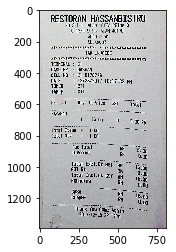

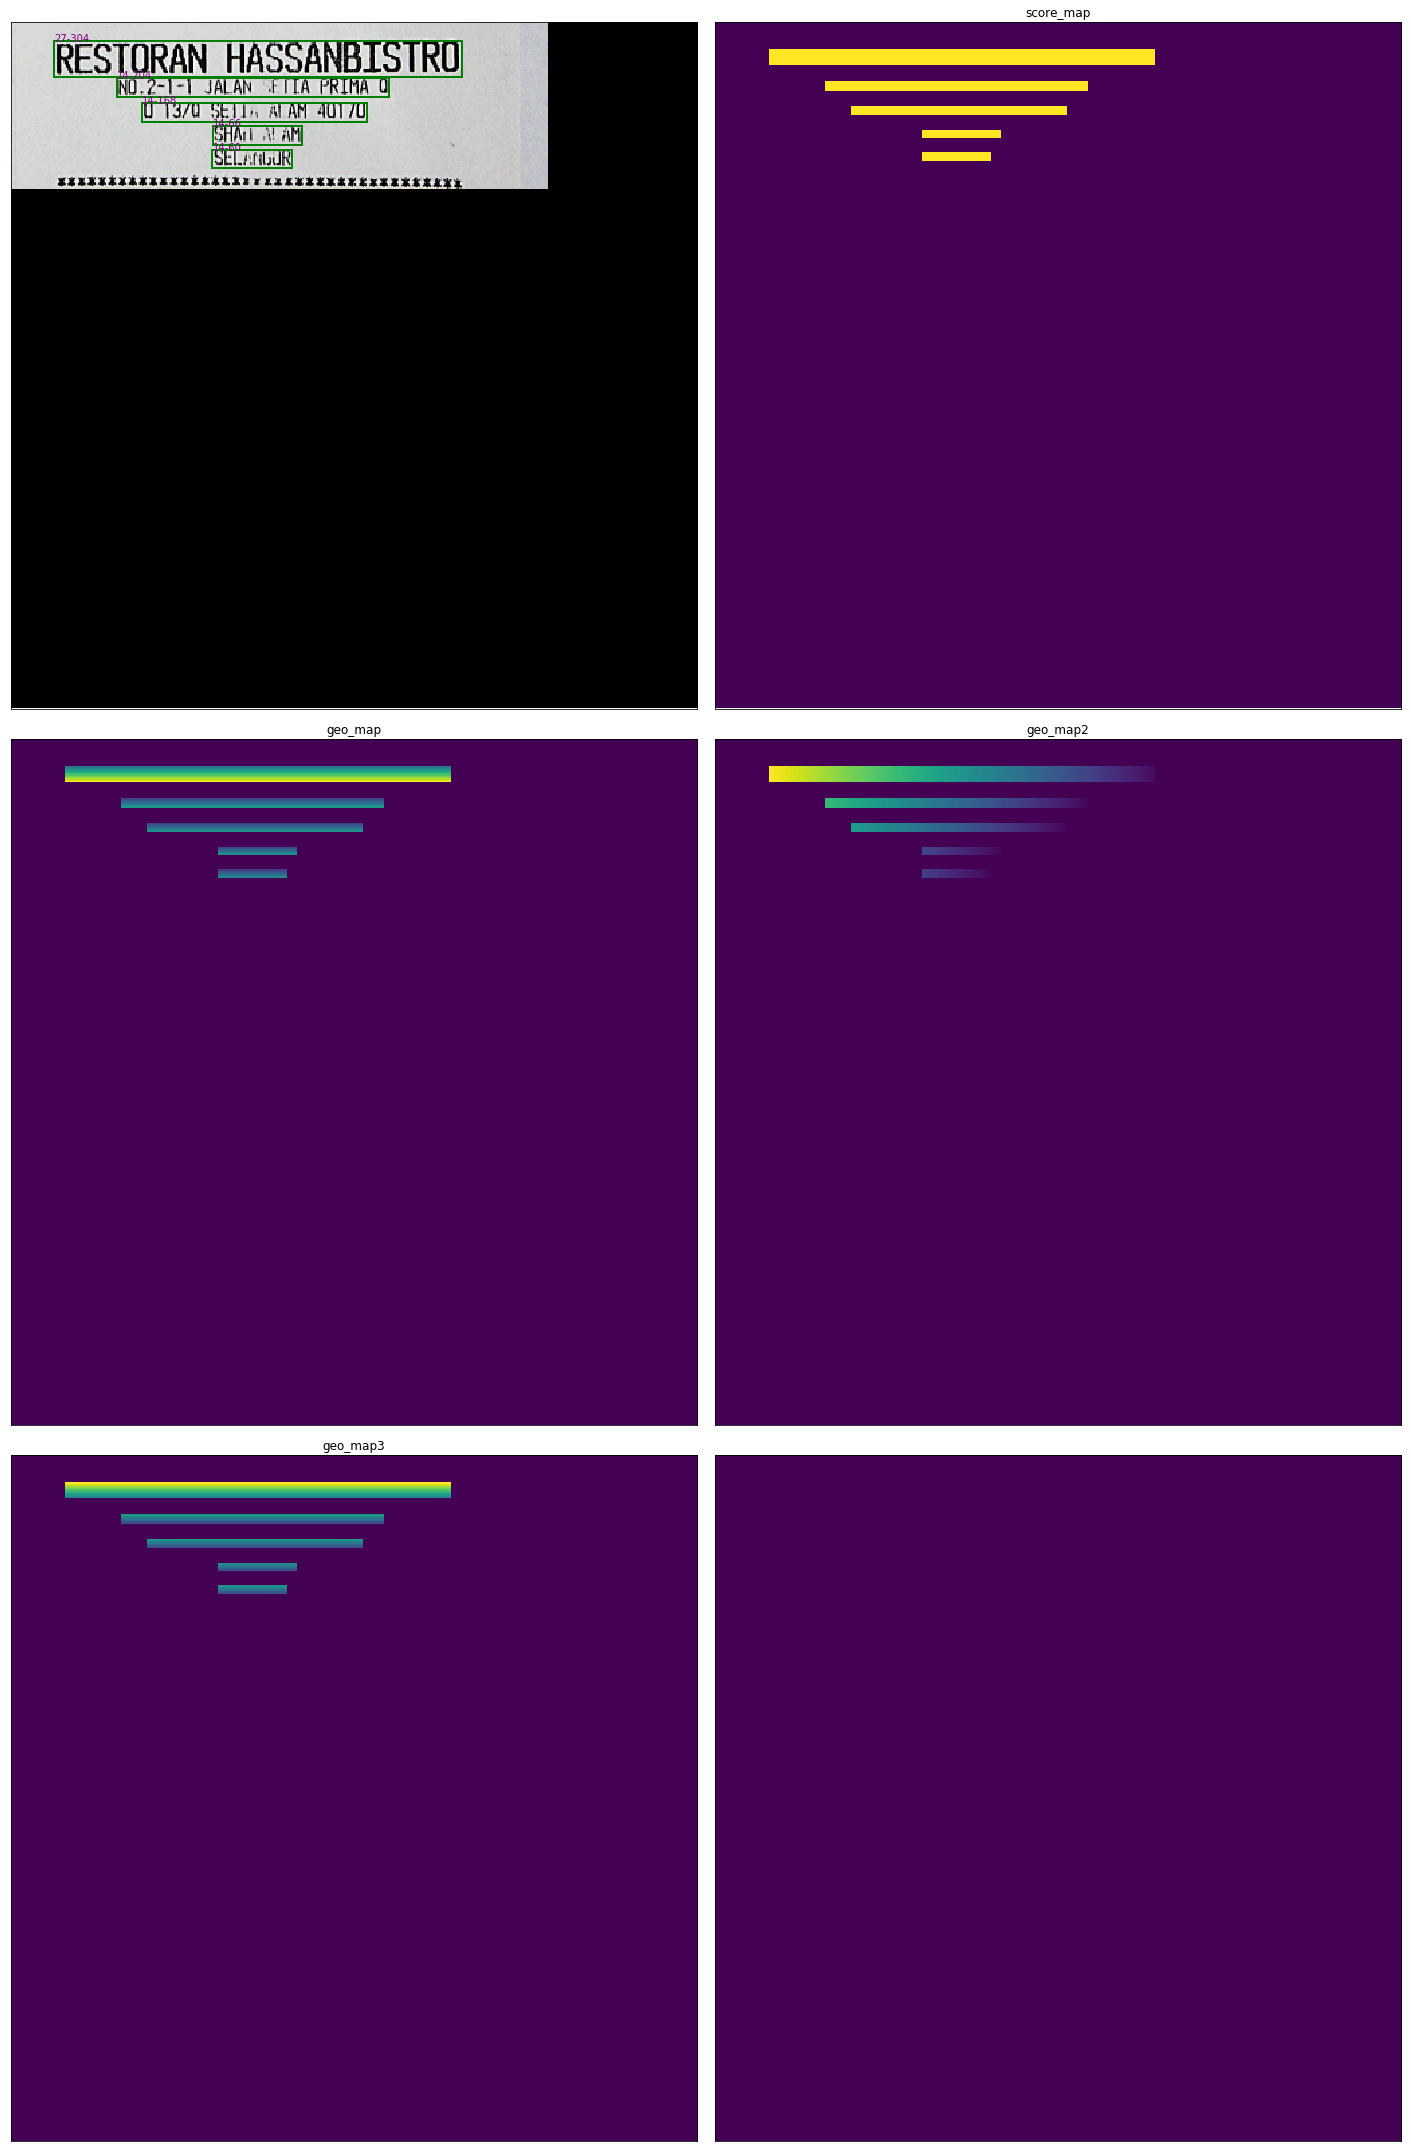

image (512, 512, 3)
score_map (128, 128, 1)
geo_map (128, 128, 5)
training_mask (128, 128, 1)


In [66]:
image, score_map, geo_map, training_mask = image_2_data(image_file_path=images[0], geometry=geometry, vis=True)

### ================================================================================

In [33]:
class GeneratorEnqueuer():
    """Builds a queue out of a data generator.

    Used in `fit_generator`, `evaluate_generator`, `predict_generator`.

    # Arguments
        generator: a generator function which endlessly yields data
        use_multiprocessing: use multiprocessing if True, otherwise threading
        wait_time: time to sleep in-between calls to `put()`
        random_seed: Initial seed for workers,
            will be incremented by one for each workers.
    """

    def __init__(self, 
                 generator,
                 use_multiprocessing=False,
                 wait_time=0.05,
                 random_seed=None):
        self.wait_time = wait_time
        self._generator = generator
        self._use_multiprocessing = use_multiprocessing
        self._threads = []
        self._stop_event = None
        self.queue = None
        self.random_seed = random_seed

    def start(self, workers=1, max_queue_size=10):
        """Kicks off threads which add data from the generator into the queue.

        # Arguments
            workers: number of worker threads
            max_queue_size: queue size
                (when full, threads could block on `put()`)
        """

        def data_generator_task():
            while not self._stop_event.is_set():
                try:
                    if self._use_multiprocessing or self.queue.qsize() < max_queue_size:
                        generator_output = next(self._generator)
                        self.queue.put(generator_output)
                    else:
                        time.sleep(self.wait_time)
                except Exception:
                    self._stop_event.set()
                    raise

        try:
            if self._use_multiprocessing:
                self.queue = multiprocessing.Queue(maxsize=max_queue_size)
                self._stop_event = multiprocessing.Event()
            else:
                self.queue = queue.Queue()
                self._stop_event = threading.Event()

            for _ in range(workers):
                if self._use_multiprocessing:
                    # Reset random seed else all children processes
                    # share the same seed
                    np.random.seed(self.random_seed)
                    thread = multiprocessing.Process(target=data_generator_task)
                    thread.daemon = True
                    if self.random_seed is not None:
                        self.random_seed += 1
                else:
                    thread = threading.Thread(target=data_generator_task)
                self._threads.append(thread)
                thread.start()
        except:
            self.stop()
            raise

    def is_running(self):
        return self._stop_event is not None and not self._stop_event.is_set()

    def stop(self, timeout=None):
        """Stops running threads and wait for them to exit, if necessary.

        Should be called by the same thread which called `start()`.

        # Arguments
            timeout: maximum time to wait on `thread.join()`.
        """
        if self.is_running():
            self._stop_event.set()

        for thread in self._threads:
            if thread.is_alive():
                if self._use_multiprocessing:
                    thread.terminate()
                else:
                    thread.join(timeout)

        if self._use_multiprocessing:
            if self.queue is not None:
                self.queue.close()

        self._threads = []
        self._stop_event = None
        self.queue = None

    def get(self):
        """Creates a generator to extract data from the queue.

        Skip the data if it is `None`.

        # Returns
            A generator
        """
        while self.is_running():
            if not self.queue.empty():
                inputs = self.queue.get()
                if inputs is not None:
                    yield inputs
            else:
                time.sleep(self.wait_time)